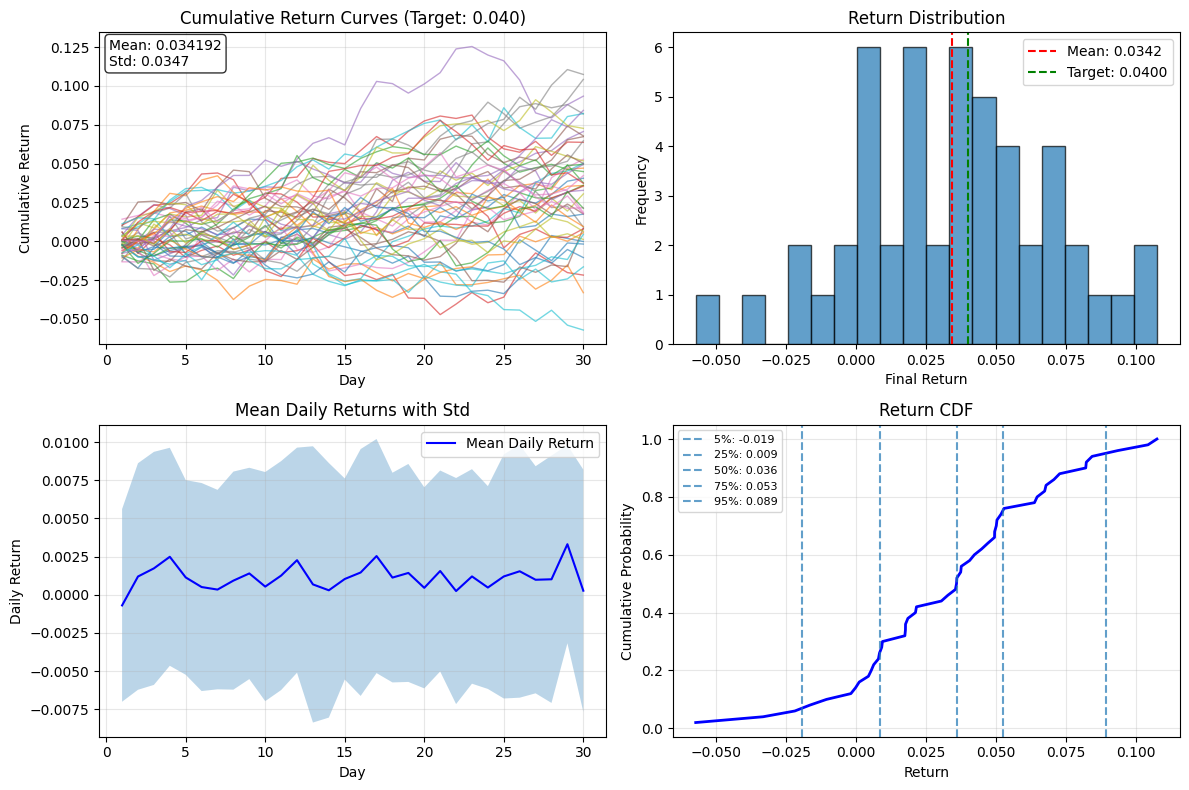

Target Return: 0.0400
Number of trajectories: 50
Mean portfolio return: 0.0342
Std portfolio return: 0.0347
Min portfolio return: -0.0571
Max portfolio return: 0.1073
Success rate (positive returns): 86.00%
Sharpe ratio: 0.9844
Saved plot: pl_analysis_target_0.040.png


In [10]:
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt
from decision_transformer.models.decision_transformer import DecisionTransformer
from decision_transformer.sum_to_one import project_portfolio_weights

model_path = 'dt_model_target_0.020_0.040_0.050_0.067_scale_0.1.pth'
eval_dataset_path = 'data/simulated_stock_eval_31x50.pkl'
train_dataset_path = 'data/simulated_stock_trajs_medium.pkl'
target_return = 0.04
scale = 0.1
K = 31
embed_dim = 128
n_layer = 3
n_head = 1
device = 'cuda'

def load_model(model_path, variant):
    device = variant['device']
    model = DecisionTransformer(
        state_dim=variant['state_dim'],
        act_dim=variant['act_dim'],
        max_length=variant['K'],
        max_ep_len=variant['max_ep_len'],
        hidden_size=variant['embed_dim'],
        n_layer=variant['n_layer'],
        n_head=variant['n_head'],
        n_inner=4*variant['embed_dim'],
        activation_function=variant.get('activation_function', 'relu'),
        n_positions=1024,
        resid_pdrop=variant.get('dropout', 0.1),
        attn_pdrop=variant.get('dropout', 0.1),
    ).to(device=device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

def evaluate_episode_with_model(model, eval_traj, target_return, max_ep_len, scale, state_mean, state_std, device):
    '''evaluate the evaj_traj with the saved trained model, return the generated actions and the resulting returns'''
    
    # Switches the model to evaluation mode (e.g., turns off dropout, etc)
    model.eval()
    
    # Load and normalize the evaluation data
    original_states = eval_traj['observations'].astype(np.float32)
    original_rewards = eval_traj['rewards'].astype(np.float32)
    state_dim = original_states.shape[1]
    act_dim = eval_traj['actions'].shape[1]
    normalized_states = (original_states - state_mean.astype(np.float32)) / state_std.astype(np.float32)
    
    # Initialize first state and empty tensors
    states = torch.from_numpy(normalized_states[0]).to(device=device, dtype=torch.float32).reshape(1, state_dim)
    # Creates a zero-tensor with 0 rows
    actions = torch.zeros((0, act_dim), device=device, dtype=torch.float32)
    rewards = torch.zeros(0, device=device, dtype=torch.float32)
    target_return_tensor = torch.tensor(target_return / scale, device=device, dtype=torch.float32).reshape(1, 1)
    timesteps = torch.tensor(0, device=device, dtype=torch.long).reshape(1, 1)
    
    # Record all actions and resulting portfolio returns.
    generated_actions = []
    portfolio_returns = []
    for t in range(len(original_states)):
        # Grow actions and rewards as we sweep through time
        actions = torch.cat([actions, torch.zeros((1, act_dim), device=device, dtype=torch.float32)], dim=0)
        rewards = torch.cat([rewards, torch.zeros(1, device=device, dtype=torch.float32)])
        with torch.no_grad():
            # Get action from the loaded model
            action = model.get_action(
                states.to(dtype=torch.float32),
                actions.to(dtype=torch.float32),
                rewards.to(dtype=torch.float32),
                target_return_tensor.to(dtype=torch.float32),
                timesteps.to(dtype=torch.long),
            )
            action = project_portfolio_weights(action.unsqueeze(0)).squeeze(0)
            actions[-1] = action
            action_np = action.detach().cpu().numpy()
            generated_actions.append(action_np.copy())
        
        # Compute return if not last timestep
        if t < len(original_states) - 1:
            p_t = original_states[t]
            p_tp1 = original_states[t + 1]
            asset_returns = (p_tp1 - p_t) / p_t
            portfolio_return = np.dot(action_np, asset_returns)
            portfolio_returns.append(float(portfolio_return))
            rewards[-1] = torch.tensor(portfolio_return, device=device, dtype=torch.float32)
            # Update return-to-go and next state
            current_rtg = target_return_tensor[0, -1].item()
            scaled_reward = portfolio_return / scale
            pred_return = torch.tensor((1 + current_rtg) / (1 + scaled_reward) - 1, device=device, dtype=torch.float32)
            target_return_tensor = torch.cat([target_return_tensor, pred_return.reshape(1, 1)], dim=1)
            if t + 1 < len(original_states):
                next_state = torch.from_numpy(normalized_states[t + 1]).to(device=device, dtype=torch.float32).reshape(1, state_dim)
                states = torch.cat([states, next_state], dim=0)
                timesteps = torch.cat([timesteps, torch.ones((1, 1), device=device, dtype=torch.long) * (t+1)], dim=1)
    return np.array(generated_actions), np.array(portfolio_returns)

def plot_profit_loss_curves(all_portfolio_returns, target_return):
    num_trajectories = len(all_portfolio_returns)
    final_returns = []
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    for i, portfolio_returns in enumerate(all_portfolio_returns):
        if len(portfolio_returns) > 0:
            cumulative_returns = np.cumprod(1 + portfolio_returns) - 1
            final_return = np.prod(1 + portfolio_returns) - 1
            final_returns.append(final_return)
            days = range(1, len(cumulative_returns) + 1)
            plt.plot(days, cumulative_returns, alpha=0.6, linewidth=1)
    plt.title(f"Cumulative Return Curves (Target: {target_return:.3f})")
    plt.xlabel("Day")
    plt.ylabel("Cumulative Return")
    plt.grid(True, alpha=0.3)
    if final_returns:
        mean_return = np.mean(final_returns)
        std_return = np.std(final_returns)
        plt.text(0.02, 0.98, f'Mean: {mean_return:.6f}\nStd: {std_return:.4f}', 
                transform=plt.gca().transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    plt.subplot(2, 2, 2)
    if final_returns:
        plt.hist(final_returns, bins=20, alpha=0.7, edgecolor='black')
        plt.xlabel('Final Return')
        plt.ylabel('Frequency')
        plt.title('Return Distribution')
        plt.axvline(np.mean(final_returns), color='red', linestyle='--', label=f'Mean: {np.mean(final_returns):.4f}')
        plt.axvline(target_return, color='green', linestyle='--', label=f'Target: {target_return:.4f}')
        plt.legend()
    plt.subplot(2, 2, 3)
    if len(all_portfolio_returns) > 0 and len(all_portfolio_returns[0]) > 0:
        daily_returns = np.array([portfolio_returns for portfolio_returns in all_portfolio_returns if len(portfolio_returns) > 0])
        mean_daily = np.mean(daily_returns, axis=0)
        std_daily = np.std(daily_returns, axis=0)
        days = range(1, len(mean_daily) + 1)
        plt.plot(days, mean_daily, 'b-', label='Mean Daily Return')
        plt.fill_between(days, mean_daily - std_daily, mean_daily + std_daily, alpha=0.3)
        plt.xlabel('Day')
        plt.ylabel('Daily Return')
        plt.title('Mean Daily Returns with Std')
        plt.grid(True, alpha=0.3)
        plt.legend()
    plt.subplot(2, 2, 4)
    if final_returns:
        sorted_returns = np.sort(final_returns)
        p = np.arange(1, len(sorted_returns) + 1) / len(sorted_returns)
        plt.plot(sorted_returns, p, 'b-', linewidth=2)
        plt.xlabel('Return')
        plt.ylabel('Cumulative Probability')
        plt.title('Return CDF')
        plt.grid(True, alpha=0.3)
        percentiles = [5, 25, 50, 75, 95]
        for pct in percentiles:
            val = np.percentile(final_returns, pct)
            plt.axvline(val, linestyle='--', alpha=0.7, label=f'{pct}%: {val:.3f}')
        plt.legend(fontsize=8)
    plt.tight_layout()
    plt.savefig(f'pl_analysis_target_{target_return:.3f}.png', dpi=300, bbox_inches='tight')
    plt.show()
    return final_returns

if __name__ == "__main__":
    with open(train_dataset_path, 'rb') as f:
        train_trajectories = pickle.load(f)
    
    train_states = []
    for path in train_trajectories:
        train_states.append(path['observations'])
    states_concat = np.concatenate(train_states, axis=0)
    state_mean = np.mean(states_concat, axis=0)
    state_std = np.std(states_concat, axis=0) + 1e-6
    
    with open(eval_dataset_path, 'rb') as f:
        eval_trajectories = pickle.load(f)
    
    state_dim = states_concat.shape[1]
    act_dim = train_trajectories[0]['actions'].shape[1]
    max_ep_len = len(eval_trajectories[0]['observations'])
    
    variant = {
        'device': device,
        'state_dim': state_dim,
        'act_dim': act_dim,
        'max_ep_len': max_ep_len,
        'K': K,
        'embed_dim': embed_dim,
        'n_layer': n_layer,
        'n_head': n_head,
    }
    
    model = load_model(model_path, variant)
    
    all_portfolio_returns = []
    for i, traj in enumerate(eval_trajectories):
        try:
            generated_actions, portfolio_returns = evaluate_episode_with_model(
                model, traj, target_return, max_ep_len, scale, state_mean, state_std, device
            )
            all_portfolio_returns.append(portfolio_returns)
        except Exception as e:
            all_portfolio_returns.append(np.array([]))
    final_returns = plot_profit_loss_curves(all_portfolio_returns, target_return)
    
    if final_returns:
        print(f"Target Return: {target_return:.4f}")
        print(f"Number of trajectories: {len(final_returns)}")
        print(f"Mean portfolio return: {np.mean(final_returns):.4f}")
        print(f"Std portfolio return: {np.std(final_returns):.4f}")
        print(f"Min portfolio return: {np.min(final_returns):.4f}")
        print(f"Max portfolio return: {np.max(final_returns):.4f}")
        print(f"Success rate (positive returns): {np.mean(np.array(final_returns) > 0):.2%}")
        print(f"Sharpe ratio: {np.mean(final_returns) / np.std(final_returns):.4f}")
        print(f"Saved plot: pl_analysis_target_{target_return:.3f}.png") 